# Visualising climate model datasets

In [11]:
# import libraries
import os
import glob
import itertools
import numpy as np
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
# from dask.distributed import Client
import climag.plot_configs as cplt
import climag.plot_facet_maps as cfacet
import importlib

In [20]:
importlib.reload(cplt)

<module 'climag.plot_configs' from '/run/media/nms/Backup/Documents/Git/ClimAg/ClimAg/climag/plot_configs.py'>

In [2]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-04-26 11:40:23.445042+00:00


In [3]:
# client = Client(n_workers=2, threads_per_worker=4, memory_limit="3GB")

In [4]:
# client

In [5]:
# Moorepark met station coords
LON, LAT = -8.26389, 52.16389

In [6]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries.gpkg")
ie_bbox = gpd.read_file(GPKG_BOUNDARY, layer="ne_10m_land_2157_IE_BBOX_DIFF")

In [7]:
datasets = {}

for exp, model, data in itertools.product(
    ["historical", "rcp45", "rcp85"],
    ["CNRM-CM5", "EC-EARTH", "HadGEM2-ES", "MPI-ESM-LR"],
    ["EURO-CORDEX", "HiResIreland"]
):
    # auto-rechunking may cause NotImplementedError with object dtype
    # where it will not be able to estimate the size in bytes of object data
    if model == "HadGEM2-ES":
        CHUNKS = 300
    else:
        CHUNKS = "auto"

    datasets[f"{data}_{model}_{exp}"] = xr.open_dataset(
        glob.glob(
            os.path.join("data", data, "IE", f"*{data}*{model}*{exp}*.nc")
        )[0],
        chunks=CHUNKS,
        decode_coords="all"
    )

    # convert HadGEM2-ES data back to 360-day calendar
    # this ensures that the correct weighting is applied when calculating
    # the weighted average
    if model == "HadGEM2-ES":
        datasets[f"{data}_{model}_{exp}"] = (
            datasets[f"{data}_{model}_{exp}"].convert_calendar(
                "360_day", align_on="year"
            )
        )

# remove spin-up year
for key in datasets.keys():
    if "historical" in key:
        datasets[key] = datasets[key].sel(time=slice("1976", "2005"))
    else:
        datasets[key] = datasets[key].sel(time=slice("2041", "2070"))
    # # normalise to keep only date in time
    # datasets[key]["time"] = datasets[key].indexes["time"].normalize()

In [8]:
varlist = ["PAR", "PET", "PP", "T"]

## Box plots

In [9]:
data_all = cplt.boxplot_data(
    datasets=datasets, varlist=varlist, lonlat=(LON, LAT)
)

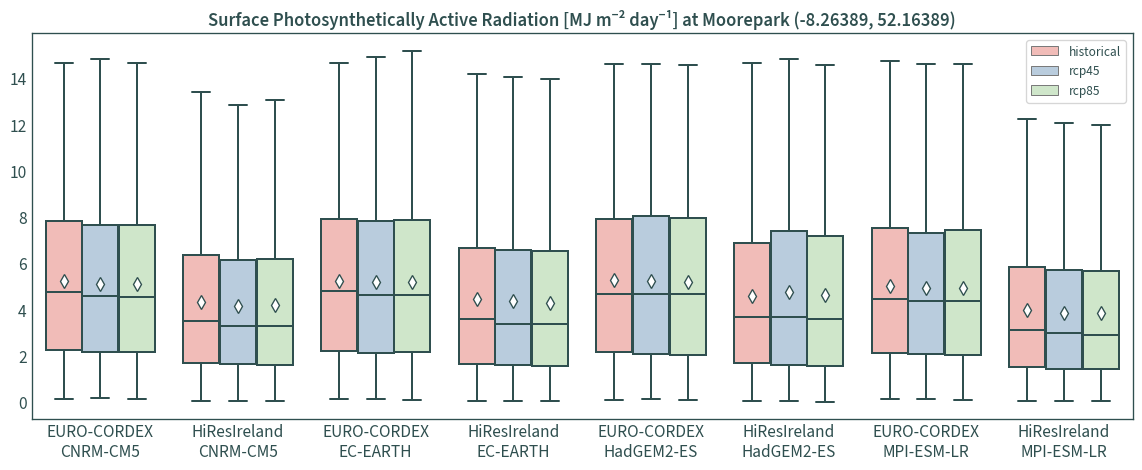

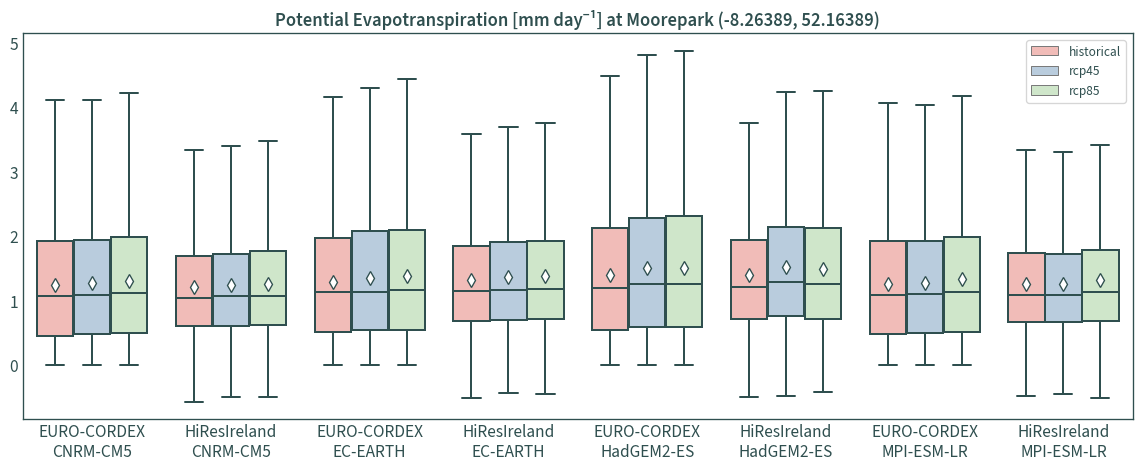

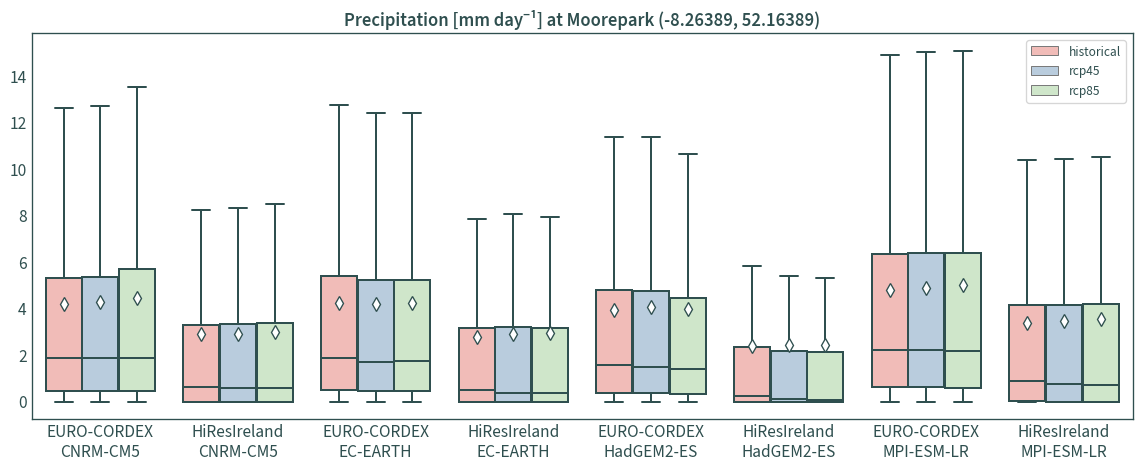

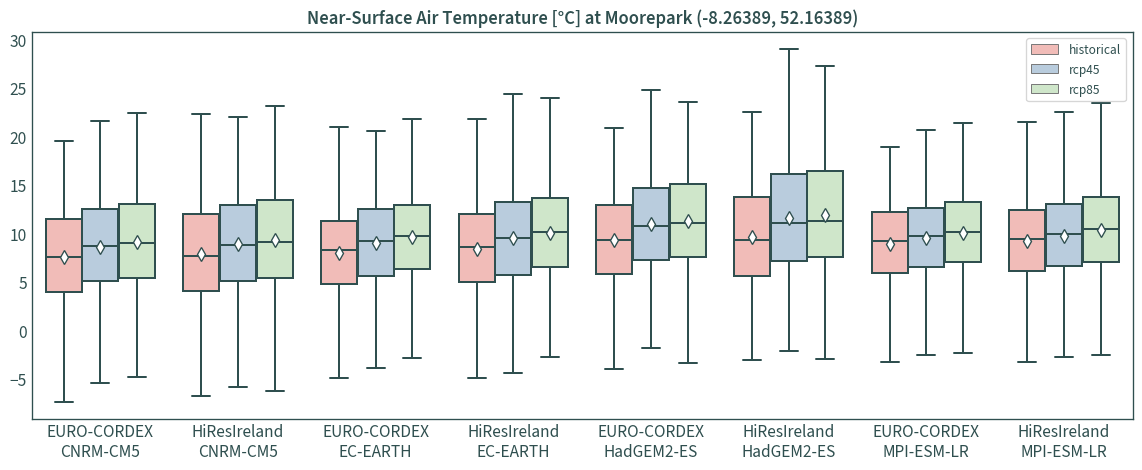

In [21]:
for var in varlist:
    cplt.boxplot_all(
        data=data_all[var],
        var=var,
        title=(
            datasets["EURO-CORDEX_EC-EARTH_rcp45"][var].attrs["long_name"] +
            f" [{datasets['EURO-CORDEX_EC-EARTH_rcp45'][var].attrs['units']}]"
            f" at Moorepark ({LON}, {LAT})"
        )
    )

## Histograms

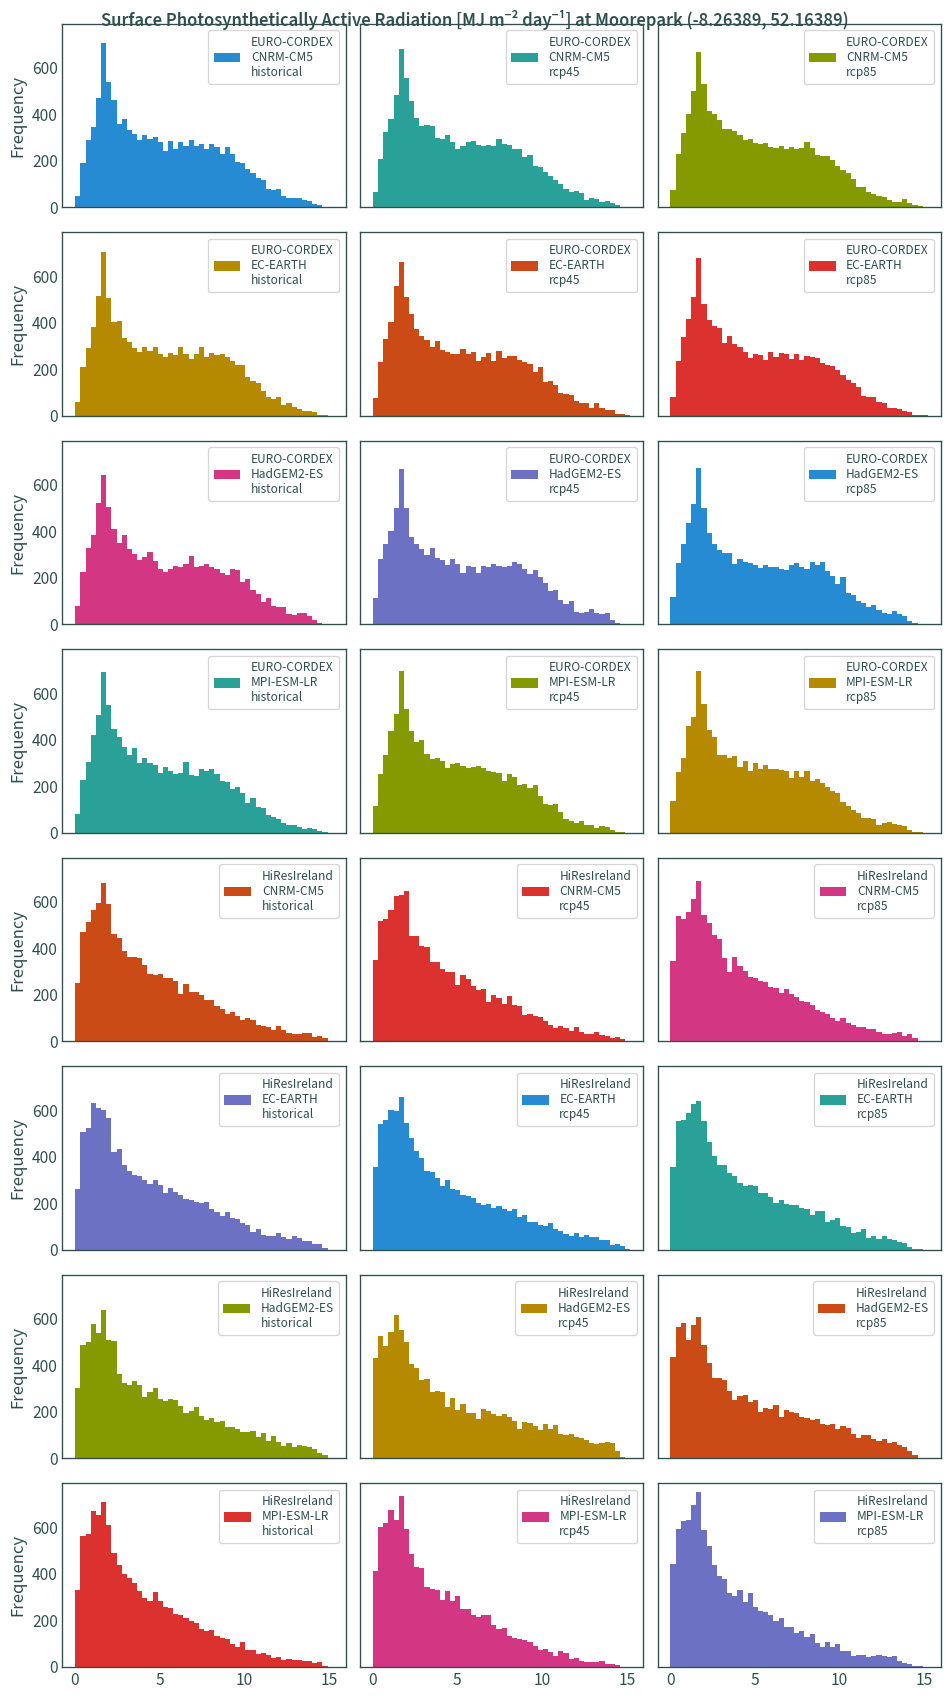

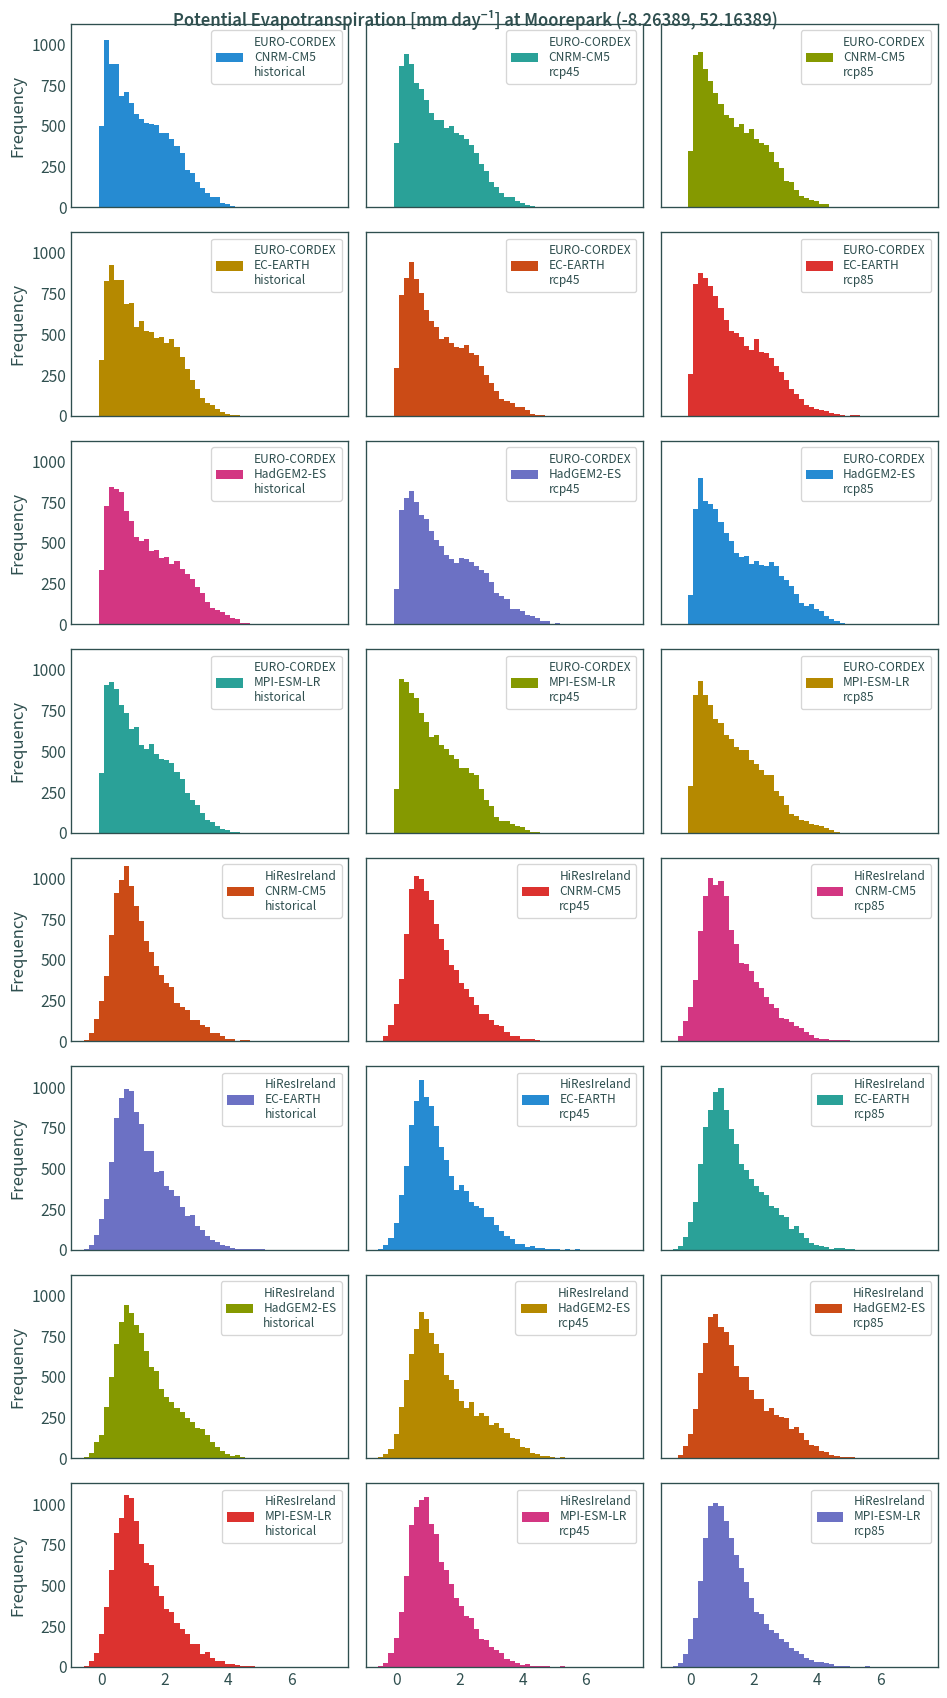

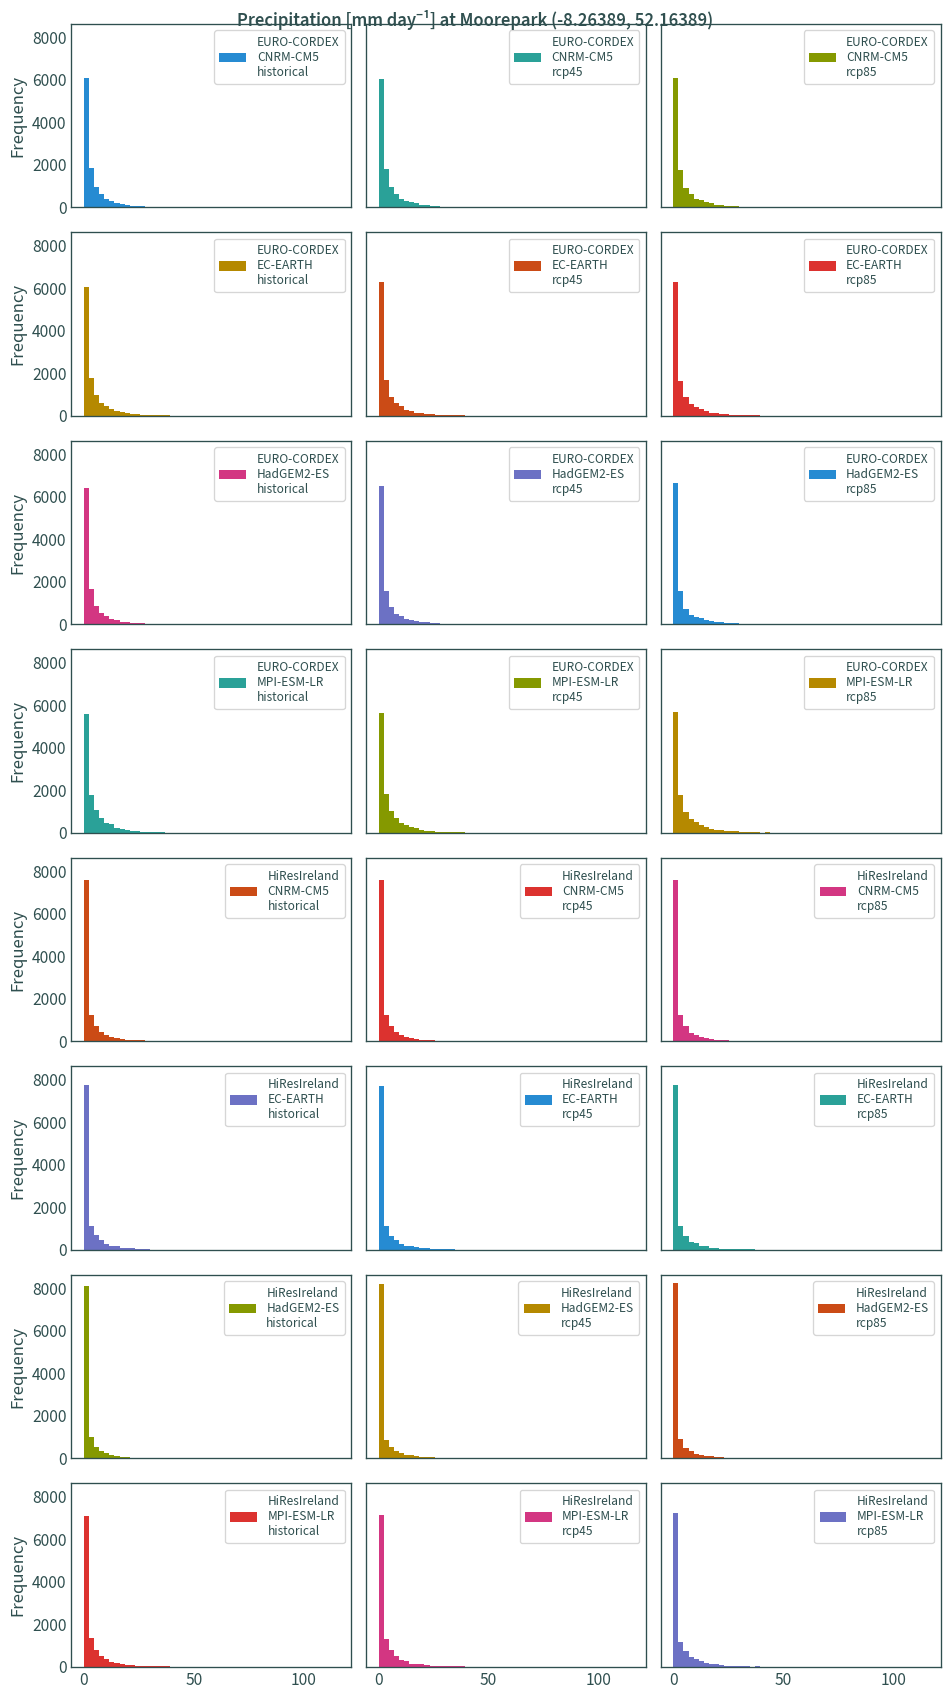

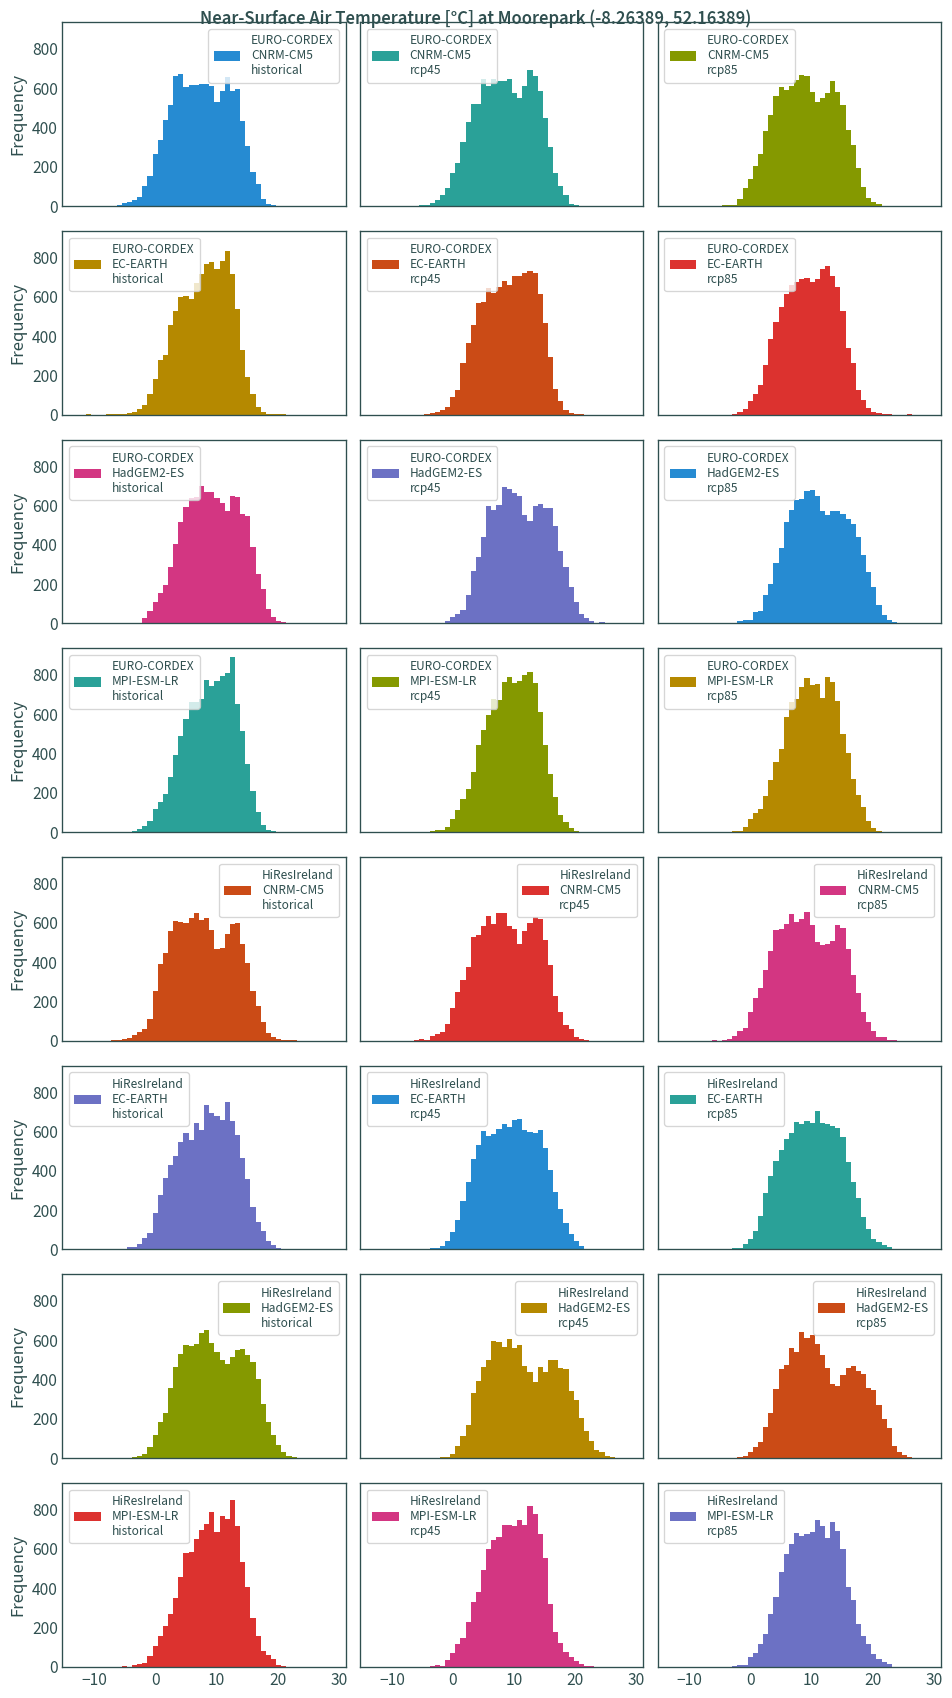

In [24]:
for var in varlist:
    data_pivot = pd.pivot_table(
        data_all[var], values=var, columns="legend",
        index=data_all[var].index
    )
    data_pivot.plot(
        kind="hist", subplots=True, figsize=(10, 18), bins=50, sharex=True,
        sharey=True, layout=(8, 3),
        title=(
            datasets["EURO-CORDEX_EC-EARTH_rcp45"][var].attrs["long_name"] +
            f" [{datasets['EURO-CORDEX_EC-EARTH_rcp45'][var].attrs['units']}]"
            f" at Moorepark ({LON}, {LAT})"
        )
    )
    plt.tight_layout()
    plt.show()

## Seasonal maps

#### Mean

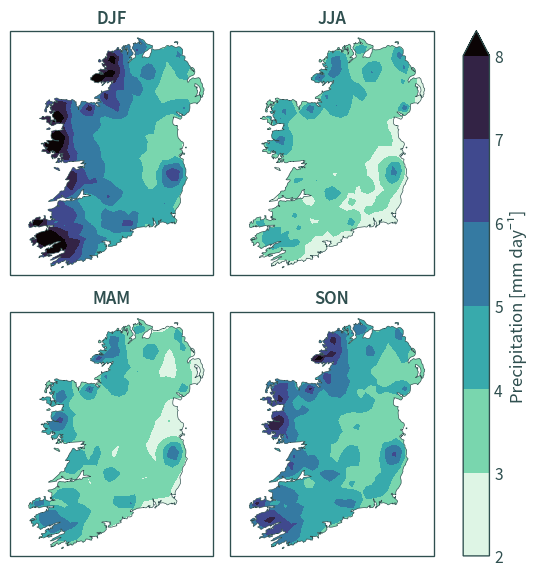

In [43]:
cfacet.plot_seasonal(
    data=datasets["EURO-CORDEX_EC-EARTH_rcp45"],
    # cbar_levels=[2 + 0.25 * n for n in range(56)],
    boundary_data=ie_bbox, stat="mean", var="PP", contour=True
)

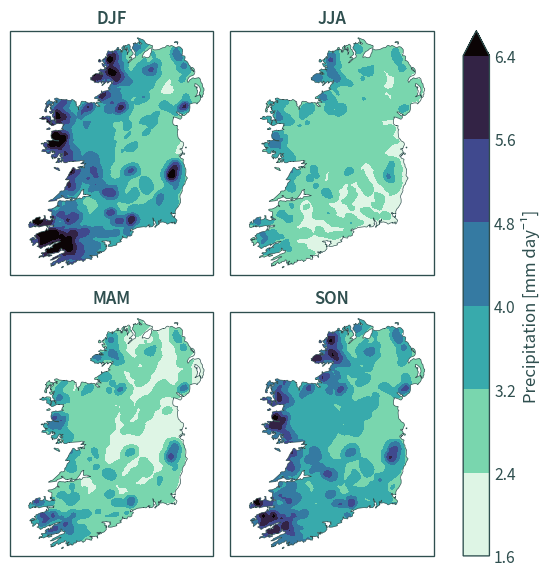

In [45]:
cfacet.plot_seasonal(
    data=datasets["HiResIreland_EC-EARTH_rcp45"],
    # cbar_levels=[2 + 0.25 * n for n in range(56)],
    boundary_data=ie_bbox, stat="mean", var="PP", contour=True
)

#### SD

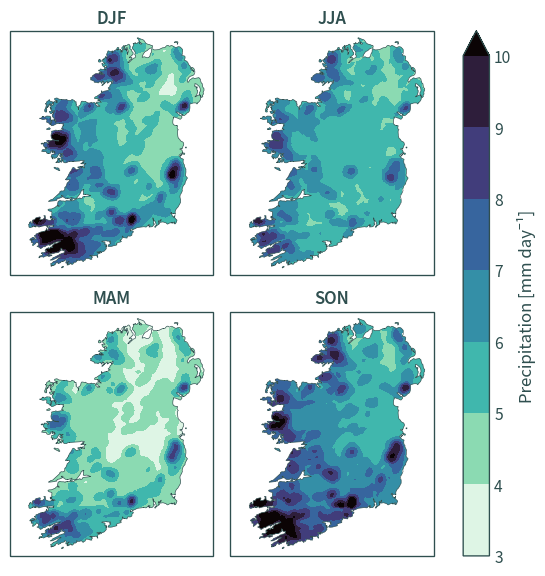

In [48]:
cfacet.plot_seasonal(
    data=datasets["HiResIreland_EC-EARTH_rcp45"],
    boundary_data=ie_bbox, stat="std", var="PP", contour=True
)

#### Max

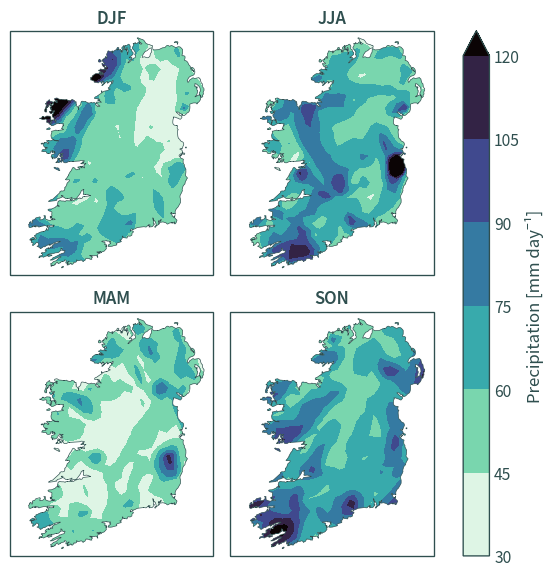

In [50]:
cfacet.plot_seasonal(
    data=datasets["EURO-CORDEX_EC-EARTH_rcp45"],
    boundary_data=ie_bbox, stat="max", var="PP", contour=True
)

#### Min

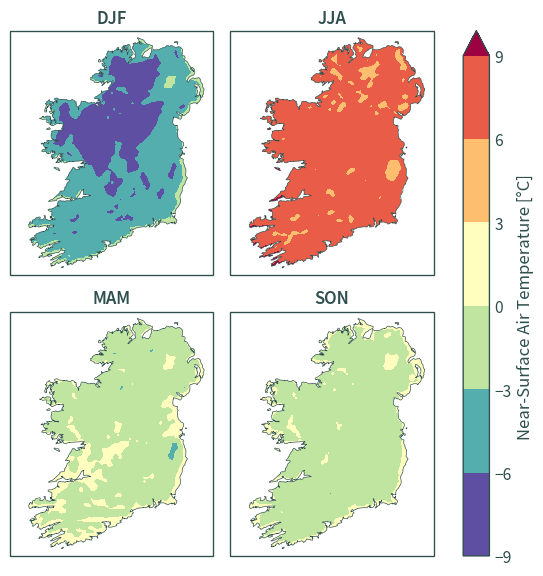

In [55]:
cfacet.plot_seasonal(
    data=datasets["HiResIreland_EC-EARTH_rcp45"],
    boundary_data=ie_bbox, stat="min", var="T", contour=True
)

### Selecting seasonal data

In [18]:
seasonal_data = datasets["EURO-CORDEX_EC-EARTH_rcp45"].sel(
    time=datasets["EURO-CORDEX_EC-EARTH_rcp45"]["time.season"] == "JJA"
)

In [19]:
seasonal_data

<xarray.Dataset>
Dimensions:       (rlat: 30, rlon: 33, time: 2760, bnds: 2)
Coordinates:
    lat           (rlat, rlon) float64 dask.array<chunksize=(30, 33), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(30, 33), meta=np.ndarray>
  * rlat          (rlat) float64 3.795 3.905 4.015 4.125 ... 6.765 6.875 6.985
  * rlon          (rlon) float64 -17.05 -16.94 -16.82 ... -13.74 -13.63 -13.53
  * time          (time) datetime64[ns] 2041-06-01T12:00:00 ... 2070-08-31T12...
    height        float64 ...
    rotated_pole  |S1 ...
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(2760, 2), meta=np.ndarray>
    spatial_ref   int64 ...
Dimensions without coordinates: bnds
Data variables:
    PET           (time, rlat, rlon) float32 dask.array<chunksize=(2760, 30, 33), meta=np.ndarray>
    PP            (time, rlat, rlon) float32 dask.array<chunksize=(2760, 30, 33), meta=np.ndarray>
    T             (time, rlat, rlon) float32 dask.array<chunksize=(2760, 30, 33), meta=np.ndarray>
    PAR           (time, rlat, rlon) float32 dask.array<chunksize=(2760, 30, 33), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                    CF-1.4
    contact:                        rossby.cordex@smhi.se
    creation_date:                  2013-07-08-T12:54:04Z
    experiment:                     RCP4.5
    experiment_id:                  rcp45
    driving_experiment:             ICHEC-EC-EARTH, rcp45, r12i1p1
    ...                             ...
    tracking_id:                    0646d817-8046-4c9b-b02b-b9e5feb3325c
    rossby_comment:                 201138: CORDEX Europe 0.11 deg | RCA4 v1 ...
    rossby_run_id:                  201138
    rossby_grib_path:               /nobackup/rossby16/rossby/joint_exp/corde...
    dataset:                        IE_EURO-CORDEX_RCA4_EC-EARTH_rcp45
    comment:                        This dataset has been clipped with the Is...

## Time series

In [ ]:
# using Moorepark met station coordinates
cds = cplt.rotated_pole_point(
    data=datasets["EURO-CORDEX_EC-EARTH_rcp45"], lon=LON, lat=LAT
)

In [44]:
data_ie = datasets["EURO-CORDEX_EC-EARTH_rcp45"].sel(
    {"rlon": cds[0], "rlat": cds[1]}, method="nearest"
)

In [45]:
data_ie

<xarray.Dataset>
Dimensions:       (time: 11323, bnds: 2)
Coordinates:
    lat           float64 dask.array<chunksize=(), meta=np.ndarray>
    lon           float64 dask.array<chunksize=(), meta=np.ndarray>
    rlat          float64 4.235
    rlon          float64 -15.83
  * time          (time) datetime64[ns] 1975-01-01T12:00:00 ... 2005-12-31T12...
    height        float64 2.0
    rotated_pole  |S1 b''
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    spatial_ref   int64 0
Dimensions without coordinates: bnds
Data variables:
    PET           (time) float32 dask.array<chunksize=(263,), meta=np.ndarray>
    PP            (time) float32 dask.array<chunksize=(263,), meta=np.ndarray>
    T             (time) float32 dask.array<chunksize=(263,), meta=np.ndarray>
    PAR           (time) float32 dask.array<chunksize=(263,), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                    CF-1.4
    contact:                        rossby.cordex@smhi.se
    creation_date:                  2013-06-24-T01:07:21Z
    experiment:                     historical
    experiment_id:                  historical
    driving_experiment:             ICHEC-EC-EARTH, historical, r12i1p1
    ...                             ...
    tracking_id:                    3315f9a7-cd0f-419c-89e5-42766ea8386d
    rossby_comment:                 201137: CORDEX Europe 0.11 deg | RCA4 v1 ...
    rossby_run_id:                  201137
    rossby_grib_path:               /nobackup/rossby16/rossby/joint_exp/corde...
    dataset:                        IE_EURO-CORDEX_RCA4_EC-EARTH_historical
    comment:                        This dataset has been clipped with the Is...

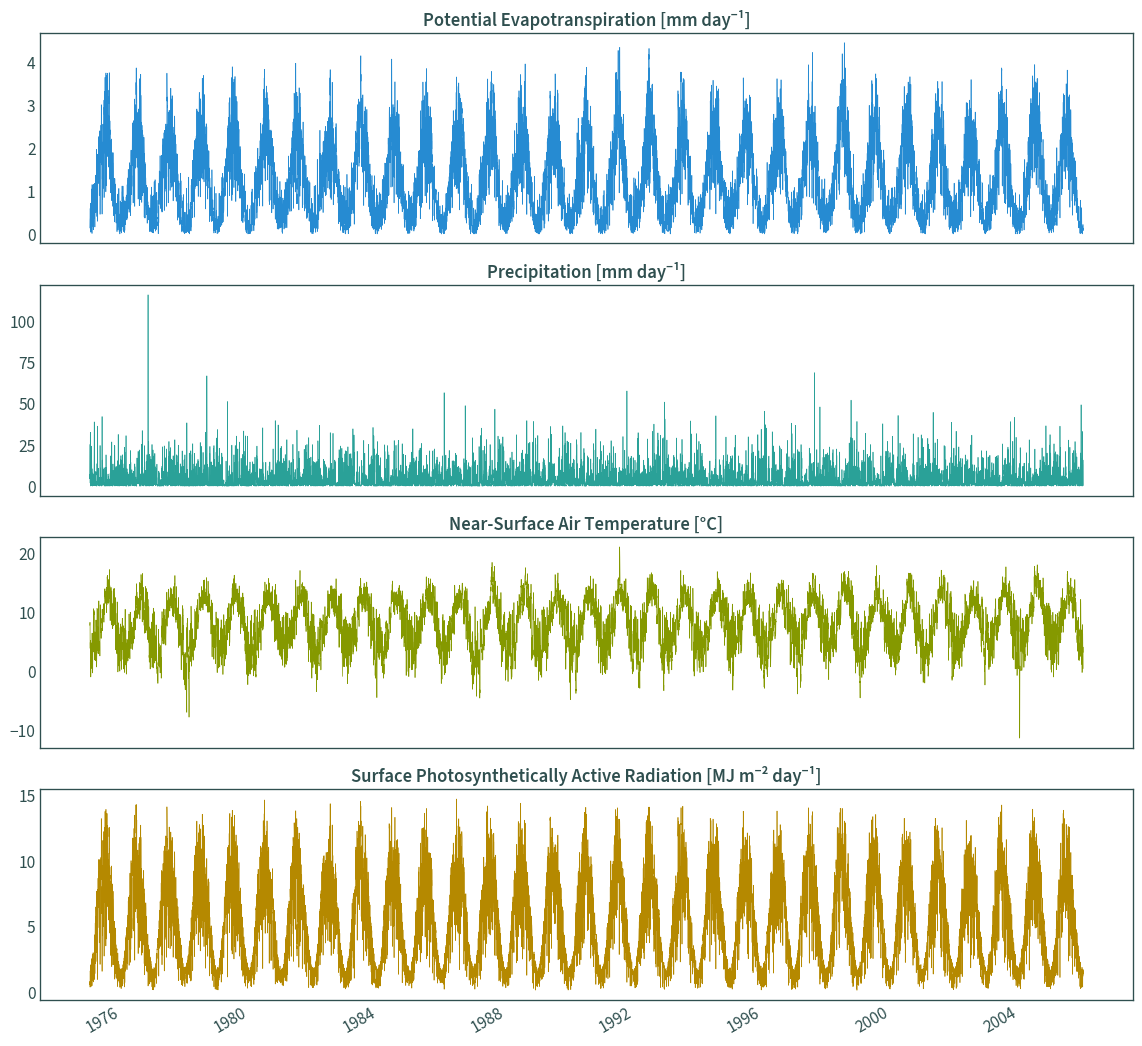

In [73]:
data_ie_df = pd.DataFrame({"time": data_ie["time"]})
# configure plot title
plot_title = []
for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.set_index("time", inplace=True)

data_ie_df.plot(
    subplots=True, layout=(4, 1), figsize=(12, 11),
    legend=False, xlabel="", title=plot_title, linewidth=.5
)

plt.tight_layout()
plt.show()

In [74]:
data_ie = data_ie.sel(time=slice("1997", "1999"))

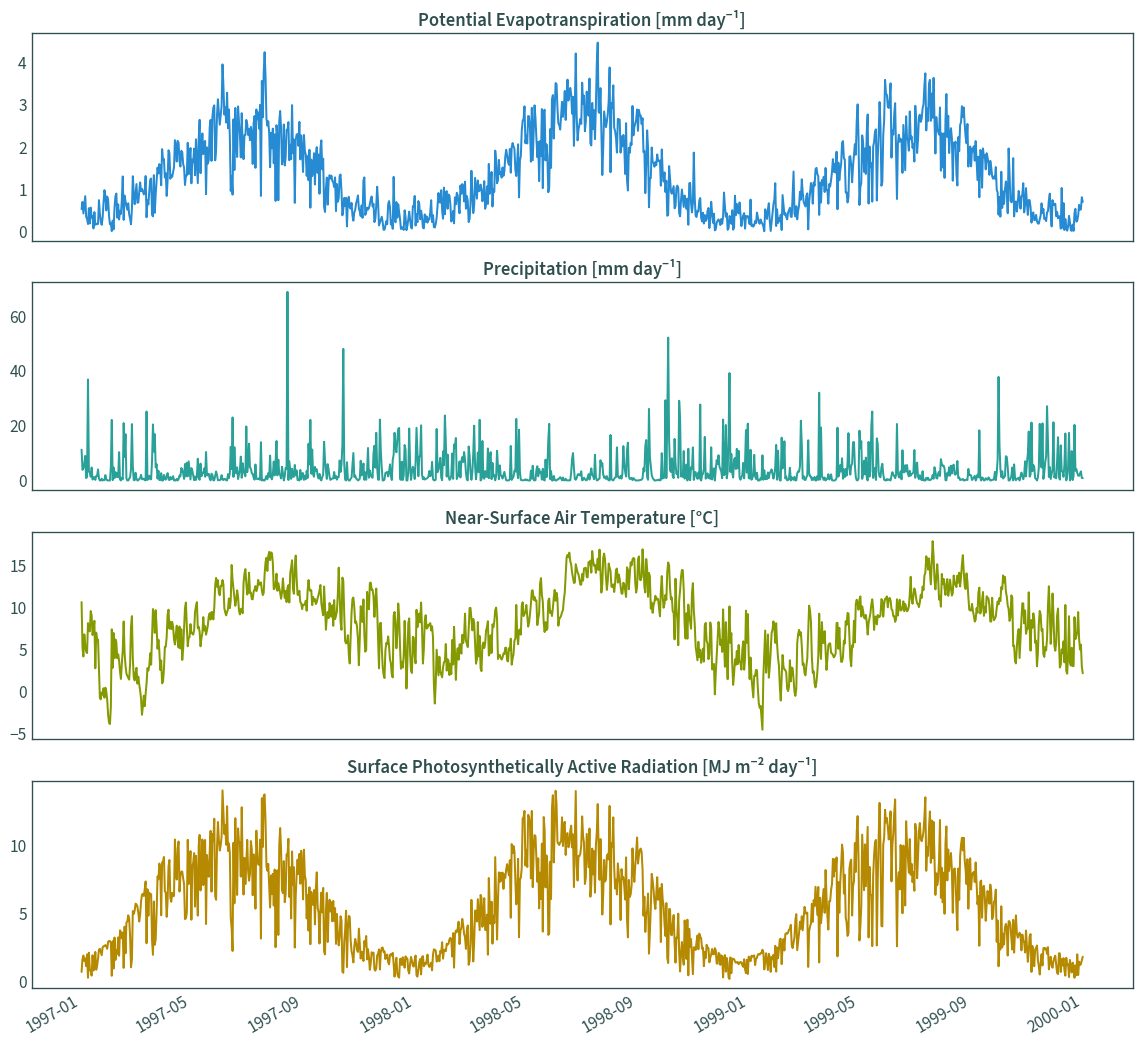

In [75]:
data_ie_df = pd.DataFrame({"time": data_ie["time"]})
# configure plot title
plot_title = []
for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.set_index("time", inplace=True)

data_ie_df.plot(
    subplots=True, layout=(4, 1), figsize=(12, 11),
    legend=False, xlabel="", title=plot_title
)

plt.tight_layout()
plt.show()

### Box plots

In [63]:
data_ie = datasets["EURO-CORDEX_EC-EARTH_rcp45"].sel(
    {"rlon": cds[0], "rlat": cds[1]}, method="nearest"
).sel(
    time=slice("1976", "2005")
)

data_ie_df = pd.DataFrame({"time": data_ie["time"]})
for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]
data_ie_df.set_index("time", inplace=True)

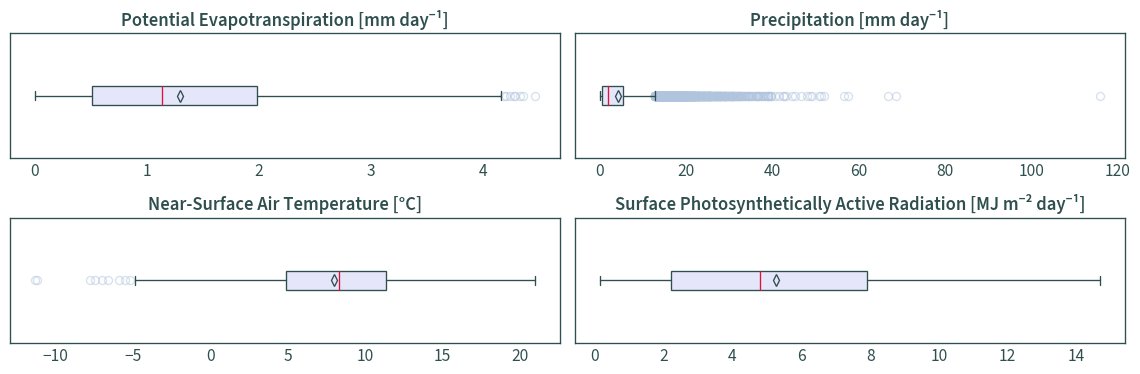

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
for ax, var in zip(axs.flat, data_ie.data_vars):
    data_ie_df.plot.box(
        column=var, vert=False, showmeans=True, ax=ax, patch_artist=True,
        color={
            "medians": "Crimson",
            "whiskers": "DarkSlateGrey",
            "caps": "DarkSlateGrey"
        },
        boxprops={"facecolor": "Lavender", "color": "DarkSlateGrey"},
        meanprops={
            "markeredgecolor": "DarkSlateGrey",
            "marker": "d",
            "markerfacecolor": (1, 1, 0, 0)  # transparent
        },
        flierprops={
            "alpha": .5, "markeredgecolor": "LightSteelBlue", "zorder": 1
        }
    )
    ax.set_title(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )
    ax.set(yticklabels=[])
plt.tight_layout()
plt.show()